In [171]:
# Imports
%matplotlib inline
import quandl
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from collections import defaultdict
import backtesters
reload(backtesters)
from backtesters import PanteraBacktester

In [134]:
# Get price data from Quandl
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin = bitcoin.shift(-1) # data set has daily open, we want daily close
bitcoin = bitcoin.loc['2010-08-17':].dropna() # Remove the 0's
bitcoin.columns = ['last']

In [172]:
# "Pantera" strategy is to buy when price breaks below 200 day MA and hold for 1 year
# First we consider the case where you have only one trade at a time
pantera = PanteraBacktester(bitcoin['last'], ml = 200, hold = 365) 
print pantera
print pantera.results()

Pantera Backtest Strategy (ms=1, ml=200, hold=365, ema=False, start=2010-08-17, end=2018-07-09)
{'Strategy_pa': 39.11, 'Market_sharpe': 3.34, 'Sharpe': 1.49, 'Market_pa': 324.8, 'Trades_per_month': 0.11, 'Trades': 10, 'Years': 7.89, 'Market': 9086214.19, 'Strategy': 1253.55}


In [179]:
pantera_trades = pantera.trades()
print pantera_trades
print
print "Arithmetic average return %.1f%%" % (pantera_trades['Return%'].mean())
print "Geometric average return %.1f%%" % (((pantera_trades['Return%']/100+1).cumprod()[-1]**(1.0/len(pantera_trades)) -1) *100)
print "Buy and Hold return for period %0.1f%%" % ((df['last'].iloc[-1] / df['last'].loc['2011-09-04'] - 1) * 100) 
print "Strategy return for period %.1f%%" % (((pantera_trades['Return%']/100+1).cumprod()[-1] -1) *100)

            Type     Entry      Exit  Days  Return%
Date                                               
2011-09-04  Long     8.467    10.593   365    25.11
2013-07-04  Long    67.858   632.780   365   832.50
2014-07-23  Long   601.180   287.300   365   -52.21
2015-08-19  Long   233.290   576.030   365   146.92
2018-02-05  Long  6838.817  6723.873   154    -1.68

Arithmetic average return 190.1%
Geometric average return 68.4%
Buy and Hold return for period 79312.7%
Strategy return for period 1253.6%


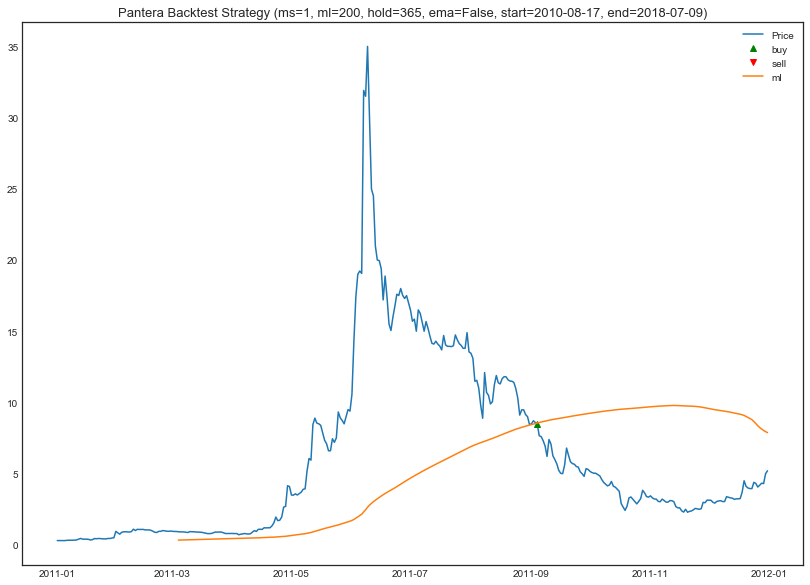

In [186]:
pantera.plot(start_date='2011', end_date='2011',figsize=(14,10),)

In [152]:
# Now we try the case where you can trade EVERY time price crosses under the 200 day MA
df = bitcoin.copy().dropna()
df['ms'] = np.round(df['last'].rolling(window=1).mean(), 8)
df['ml'] = np.round(df['last'].rolling(window=200).mean(), 8)
df['mdiff'] = df['ms'] - df['ml']
df['buy'] = np.where( (df['mdiff'] < 0) & (df['mdiff'].shift(1)>0), 1, 0)
df['Buy'] = np.where( (df['mdiff'] < 0) & (df['mdiff'].shift(1)>0), df['last'], np.NAN) # used for chart
trades = df[df['buy'] == 1]

In [178]:
results = defaultdict(list)

for date, row in trades.iterrows():
    
    sell_date = date + pd.DateOffset(days=365)
    results['Date'].append(date)
    results['Buy'].append(row['last'])
    results['Sell Date'].append(sell_date)
    
    try:
        sell_price = df['last'].loc[sell_date]
    except:
        sell_price = df['last'][-1] # use lastest value if 365 days not up
            
    results['Sell'].append(sell_price)
    results['Return%'].append((sell_price / row['last'] - 1) * 100.0)

results_df = pd.DataFrame(results, columns=['Date','Buy','Sell','Sell Date','Return%'])
print np.round(results_df,2)
print
print "Arithmetic average return %.1f%%" % (results_df['Return%'].mean())
print "Geometric average return %.1f%%" % (((results_df['Return%']/100+1).cumprod().values[-1]**(1.0/len(trades)) -1) *100)
print "Buy and Hold return for period %0.1f%%" % ((df['last'].iloc[-1] / df['last'].loc['2011-09-04'] - 1) * 100) 
print "Strategy return for period %0.1f%%" % (((results_df['Return%'] / 100 + 1).cumprod().values[-1] - 1) * 100)

         Date      Buy     Sell  Sell Date  Return%
0  2011-09-04     8.47    10.59 2012-09-03    25.11
1  2012-01-16     6.98    14.69 2013-01-15   110.44
2  2012-02-11     5.85    24.20 2013-02-10   313.60
3  2012-03-07     5.00    42.98 2013-03-07   759.60
4  2013-07-04    67.86   632.78 2014-07-04   832.50
5  2013-10-01   104.47   375.85 2014-10-01   259.77
6  2014-03-26   520.20   248.63 2015-03-26   -52.20
7  2014-06-01   631.49   224.83 2015-06-01   -64.40
8  2014-06-03   644.66   225.54 2015-06-03   -65.01
9  2014-06-09   649.89   228.01 2015-06-09   -64.92
10 2014-07-23   601.18   287.30 2015-07-23   -52.21
11 2014-08-01   591.59   280.69 2015-08-01   -52.55
12 2014-08-04   580.21   282.69 2015-08-04   -51.28
13 2014-08-10   578.97   265.85 2015-08-10   -54.08
14 2015-08-19   233.29   576.03 2016-08-18   146.92
15 2015-10-06   245.25   612.35 2016-10-05   149.68
16 2018-02-05  6838.82  6723.87 2019-02-05    -1.68
17 2018-03-10  8746.00  6723.87 2019-03-10   -23.12
18 2018-03-1

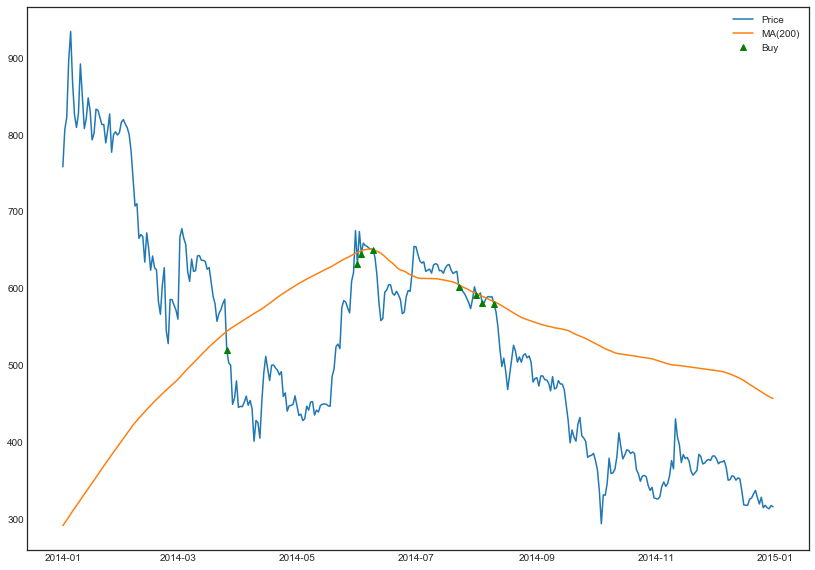

In [185]:
# Chart showing price, MA, and buys
temp = df.loc['2014']
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(temp['last'], label='Price')
ax.plot(temp['ml'], label='MA(200)')
ax.plot(temp['Buy'],color='g', linestyle='None', marker='^', label='Buy')
plt.legend();